In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_FILE_PATH = r'C:\Users\User\Desktop\Global Natural Gas Dynamics\bp-energy-outlook-2024-summary-tables.xlsx'
CONSUMPTION_SHEET_NAME = 'Gas - Bcm'
PRODUCTION_SHEET_NAME = 'Natural gas Production - Bcm'

Data Extraction and Preprocessing

In [4]:
YEARS_TO_ANALYZE = [
    2000, 2005, 2010, 2015, 2020, 2022, # Historical
    2025, 2030, 2035, 2040, 2045, 2050  # Projected
]

In [5]:
REGIONS_TO_SELECT = [
    'North America',
    'S. & Cent. America',
    'Europe',
    'CIS',
    'Middle East',
    'Africa',
    'Asia Pacific'
]

COUNTRIES_TO_SELECT = [
    'United States', # Listed under North America
    'Brazil',        # Listed under S. & Cent. America
    'UK',            # Listed under Europe
    'Russia',        # Listed under CIS
    'China',         # Listed under Asia Pacific
    'India'          # Listed under Asia Pacific
]

SUB_REGIONAL_AGGREGATES_TO_SELECT = [
    'EU',             # From Europe
    'Asia Emerging'   # From Asia Pacific
]

GLOBAL_AGGREGATES_TO_SELECT = [
    'World',
    'of which: Developed', 
    'Emerging',
    'Emerging exc. China'
]

ALL_AREAS_OF_INTEREST = (
    REGIONS_TO_SELECT +
    COUNTRIES_TO_SELECT +
    SUB_REGIONAL_AGGREGATES_TO_SELECT +
    GLOBAL_AGGREGATES_TO_SELECT
)

HEADER_ROW_INDEX = 3

In [6]:
# --- Helper Function to Load and Process Data ---
def load_and_process_outlook_data(file_path, sheet_name, areas_of_interest, years, header_index):
    """Loads, filters, and transforms BP Energy Outlook data."""
    print(f"--- Processing Sheet: {sheet_name} ---")
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=header_index)
        print(f"Successfully read sheet: {sheet_name}")
        print(f"Initial columns: {df.columns.tolist()}")
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path.")
        return None
    except ValueError as e:
        print(f"Error reading sheet '{sheet_name}': {e}. Check sheet name and header_index.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while reading {sheet_name}: {e}")
        return None

    # Rename the first column (which contains area names) to 'Area'
    # It might be unnamed or have a generic name from read_excel.
    if df.columns[0].startswith('Unnamed:'):
        df.rename(columns={df.columns[0]: 'Area'}, inplace=True)
    elif 'Area' not in df.columns[0] and 'region' not in df.columns[0].lower() and 'country' not in df.columns[0].lower():
         df.rename(columns={df.columns[0]: 'Area'}, inplace=True)

    if 'Area' not in df.columns:
        print(f"Error: 'Area' column (expected first column for names) not found in {sheet_name}. Current columns: {df.columns.tolist()}")
        return None

    # Clean area names: strip whitespace
    df['Area'] = df['Area'].astype(str).str.strip()

    # Filter for selected areas
    df_filtered = df[df['Area'].isin(areas_of_interest)].copy()

    if df_filtered.empty:
        print(f"Warning: No data found for any of the specified areas_of_interest in sheet '{sheet_name}'.")
        print(f"Areas searched for: {areas_of_interest}")
        print(f"Areas found in sheet (first 20): {df['Area'].unique()[:20]}")
        return None

    # Select only 'Area' and the specified year columns
    # Convert all column headers to string to handle mixed types (int years, string notes)
    df_filtered.columns = df_filtered.columns.astype(str)
    
    # Identify actual year columns present in the DataFrame that are in YEARS_TO_ANALYZE
    year_cols_as_str = [str(y) for y in years] # Convert target years to string for matching
    
    valid_year_cols_in_df = [col for col in df_filtered.columns if col in year_cols_as_str]
    
    if not valid_year_cols_in_df:
        print(f"Error: None of the specified years {years} (as strings) found as columns in sheet '{sheet_name}' after filtering.")
        print(f"Available columns after filtering: {df_filtered.columns.tolist()}")
        return None
        
    df_selected_years = df_filtered[['Area'] + valid_year_cols_in_df]

    # Melt dataframe to long format
    df_melted = df_selected_years.melt(id_vars=['Area'],
                                       value_vars=valid_year_cols_in_df,
                                       var_name='Year',
                                       value_name='Value_Bcm')
    
    df_melted['Year'] = pd.to_numeric(df_melted['Year'])
    df_melted['Value_Bcm'] = pd.to_numeric(df_melted['Value_Bcm'], errors='coerce')
    df_melted.fillna(0, inplace=True) # Assuming missing/non-numeric means zero for this context

    return df_melted

In [7]:
# --- Load Production Data ---
df_production = load_and_process_outlook_data(DATA_FILE_PATH, PRODUCTION_SHEET_NAME, ALL_AREAS_OF_INTEREST, YEARS_TO_ANALYZE, HEADER_ROW_INDEX)
if df_production is not None:
    df_production['Type'] = 'Production'
    print("Production Data Summary:")
    print(df_production.head())
    print(f"Unique areas loaded for Production: {df_production['Area'].unique()}")
    print(f"Years loaded: {sorted(df_production['Year'].unique())}")

--- Processing Sheet: Natural gas Production - Bcm ---
Successfully read sheet: Natural gas Production - Bcm
Initial columns: ['Billion cubic meters', 2000, 2005, 2010, 2015, 2020, 2022, '2000-2022', 'Unnamed: 8', 2025, 2030, 2035, 2040, 2045, 2050, '2022-2050', 'Unnamed: 16', '2025.1', '2030.1', '2035.1', '2040.1', '2045.1', '2050.1', '2022-2050.1']
Production Data Summary:
                 Area  Year  Value_Bcm        Type
0       North America  2000      728.3  Production
1       United States  2000      518.6  Production
2  S. & Cent. America  2000      101.7  Production
3              Brazil  2000        7.7  Production
4              Europe  2000      309.9  Production
Unique areas loaded for Production: ['North America' 'United States' 'S. & Cent. America' 'Brazil' 'Europe'
 'EU' 'UK' 'CIS' 'Russia' 'Middle East' 'Africa' 'Asia Pacific' 'China'
 'India' 'Asia Emerging' 'World' 'Emerging' 'Emerging exc. China']
Years loaded: [2000, 2005, 2010, 2015, 2020, 2022, 2025, 2030, 2035, 

In [8]:
# --- Load Consumption Data ---
df_consumption = load_and_process_outlook_data(DATA_FILE_PATH, CONSUMPTION_SHEET_NAME, ALL_AREAS_OF_INTEREST, YEARS_TO_ANALYZE, HEADER_ROW_INDEX)
if df_consumption is not None:
    df_consumption['Type'] = 'Consumption'
    print("\nConsumption Data Summary:")
    print(df_consumption.head())
    print(f"Unique areas loaded for Consumption: {df_consumption['Area'].unique()}")
    print(f"Years loaded: {sorted(df_consumption['Year'].unique())}")

--- Processing Sheet: Gas - Bcm ---
Successfully read sheet: Gas - Bcm
Initial columns: ['Billion cubic metres', 2000, 2005, 2010, 2015, 2020, 2022, '2000-2022', 'Unnamed: 8', 2025, 2030, 2035, 2040, 2045, 2050, '2022-2050', 'Unnamed: 16', '2025.1', '2030.1', '2035.1', '2040.1', '2045.1', '2050.1', '2022-2050.1']

Consumption Data Summary:
                 Area  Year  Value_Bcm         Type
0       North America  2000      753.5  Consumption
1       United States  2000      628.4  Consumption
2  S. & Cent. America  2000       98.3  Consumption
3              Brazil  2000        9.7  Consumption
4              Europe  2000      558.5  Consumption
Unique areas loaded for Consumption: ['North America' 'United States' 'S. & Cent. America' 'Brazil' 'Europe'
 'EU' 'UK' 'CIS' 'Russia' 'Middle East' 'Africa' 'Asia Pacific' 'China'
 'India' 'Asia Emerging' 'World' 'Emerging' 'Emerging exc. China']
Years loaded: [2000, 2005, 2010, 2015, 2020, 2022, 2025, 2030, 2035, 2040, 2045, 2050]


In [9]:
# --- Combine Data ---
df_combined = None
if df_production is not None and df_consumption is not None:
    df_combined = pd.concat([df_production, df_consumption], ignore_index=True)
elif df_production is not None:
    df_combined = df_production
    print("Warning: Only Production data was loaded.")
elif df_consumption is not None:
    df_combined = df_consumption
    print("Warning: Only Consumption data was loaded.")
else:
    print("Error: No data loaded for Production or Consumption. Further steps will be skipped.")

if df_combined is not None and not df_combined.empty:
    # Standardize "Developed" name if needed, though direct match is preferred
    df_combined['Area'] = df_combined['Area'].replace({'of which: Developed': 'Developed'})
    ALL_AREAS_OF_INTEREST = [name.replace('of which: Developed', 'Developed') for name in ALL_AREAS_OF_INTEREST]

    print("\nCombined Data Summary:")
    print(df_combined.head())
    print(df_combined.tail())
    print(f"Unique areas in combined data: {df_combined['Area'].unique()}")
    print(f"Data types:\n{df_combined.dtypes}")
else:
    print("Combined data is empty or None. Cannot proceed with analysis.")


Combined Data Summary:
                 Area  Year  Value_Bcm        Type
0       North America  2000      728.3  Production
1       United States  2000      518.6  Production
2  S. & Cent. America  2000      101.7  Production
3              Brazil  2000        7.7  Production
4              Europe  2000      309.9  Production
                    Area  Year  Value_Bcm         Type
427                India  2050      190.8  Consumption
428        Asia Emerging  2050      444.0  Consumption
429                World  2050     4728.6  Consumption
430             Emerging  2050     3448.7  Consumption
431  Emerging exc. China  2050     2943.0  Consumption
Unique areas in combined data: ['North America' 'United States' 'S. & Cent. America' 'Brazil' 'Europe'
 'EU' 'UK' 'CIS' 'Russia' 'Middle East' 'Africa' 'Asia Pacific' 'China'
 'India' 'Asia Emerging' 'World' 'Emerging' 'Emerging exc. China']
Data types:
Area          object
Year           int64
Value_Bcm    float64
Type          object
dt

Calculate Growth Rates

In [10]:
if df_combined is not None and not df_combined.empty:
    df_combined = df_combined.sort_values(by=['Area', 'Type', 'Year'])

    # --- Calculate Year-over-Year (YoY) Percentage Change ---
    df_combined['YoY_Change_%'] = df_combined.groupby(['Area', 'Type'])['Value_Bcm'].pct_change() * 100
    df_combined['YoY_Change_%'].fillna(0, inplace=True) # Fill NaN for the first year

    # --- Calculate Compound Annual Growth Rate (CAGR) ---
    # We can calculate CAGR for historical (e.g., 2000-2022) and projected (e.g., 2022-2050)
    
    HISTORICAL_START_YEAR = 2000 # Adjust if needed
    HISTORICAL_END_YEAR = 2022   # This is our pivot year
    PROJECTED_END_YEAR = 2050    # Adjust if needed

    def calculate_cagr(series, start_year_val, end_year_val):
        start_val_series = series[series['Year'] == start_year_val]['Value_Bcm']
        end_val_series = series[series['Year'] == end_year_val]['Value_Bcm']

        if start_val_series.empty or end_val_series.empty:
            return None # Not enough data
            
        start_value = start_val_series.iloc[0]
        end_value = end_val_series.iloc[0]
        
        num_years = end_year_val - start_year_val
        
        if start_value == 0 or start_value is None or end_value is None or num_years <= 0:
            return 0.0 # Avoid division by zero or invalid period, or if no growth
        
        cagr = ((end_value / start_value) ** (1 / num_years)) - 1
        return cagr * 100

    cagr_data_list = []
    for (area, type_val), group in df_combined.groupby(['Area', 'Type']):
        # Historical CAGR
        cagr_hist = calculate_cagr(group, HISTORICAL_START_YEAR, HISTORICAL_END_YEAR)
        if cagr_hist is not None:
             cagr_data_list.append({'Area': area, 'Type': type_val, 'CAGR_Period': f'{HISTORICAL_START_YEAR}-{HISTORICAL_END_YEAR}', 'CAGR_%': cagr_hist})

        # Projected CAGR
        cagr_proj = calculate_cagr(group, HISTORICAL_END_YEAR, PROJECTED_END_YEAR)
        if cagr_proj is not None:
            cagr_data_list.append({'Area': area, 'Type': type_val, 'CAGR_Period': f'{HISTORICAL_END_YEAR}-{PROJECTED_END_YEAR}', 'CAGR_%': cagr_proj})
            
    df_cagr = pd.DataFrame(cagr_data_list)
    
    print("\nCAGR Data:")
    if not df_cagr.empty:
        print(df_cagr.head())
    else:
        print("CAGR DataFrame is empty. Check year ranges and data availability.")
else:
    print("Skipping growth rate calculations as df_combined is not available or empty.")


CAGR Data:
            Area         Type CAGR_Period    CAGR_%
0         Africa  Consumption   2000-2022  5.010621
1         Africa  Consumption   2022-2050  2.462451
2         Africa   Production   2000-2022  2.818244
3         Africa   Production   2022-2050  1.830589
4  Asia Emerging  Consumption   2000-2022  2.992518


Initial Visualization

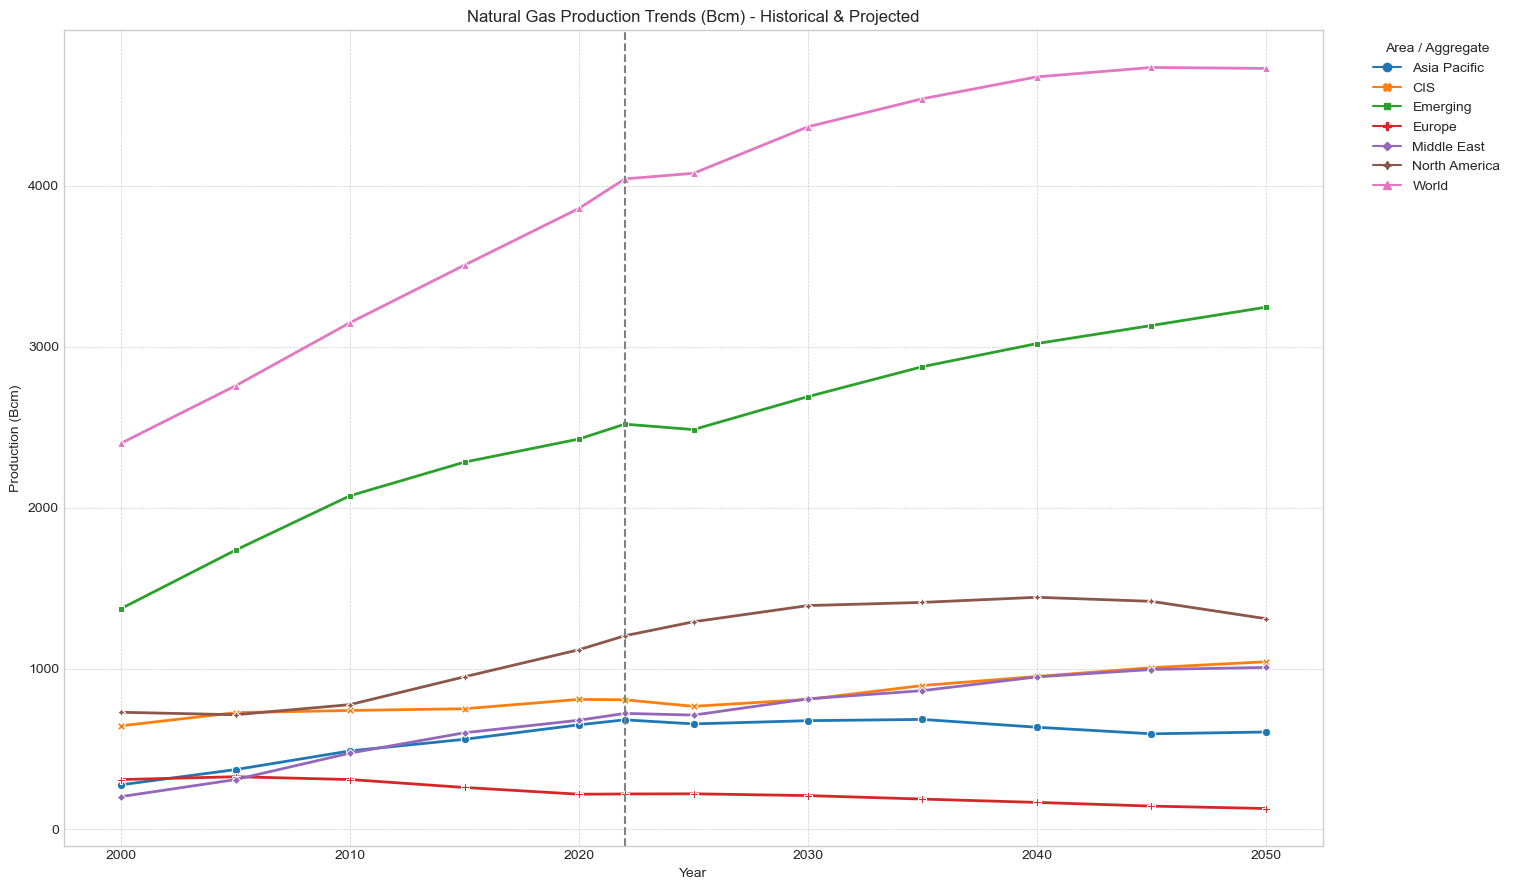

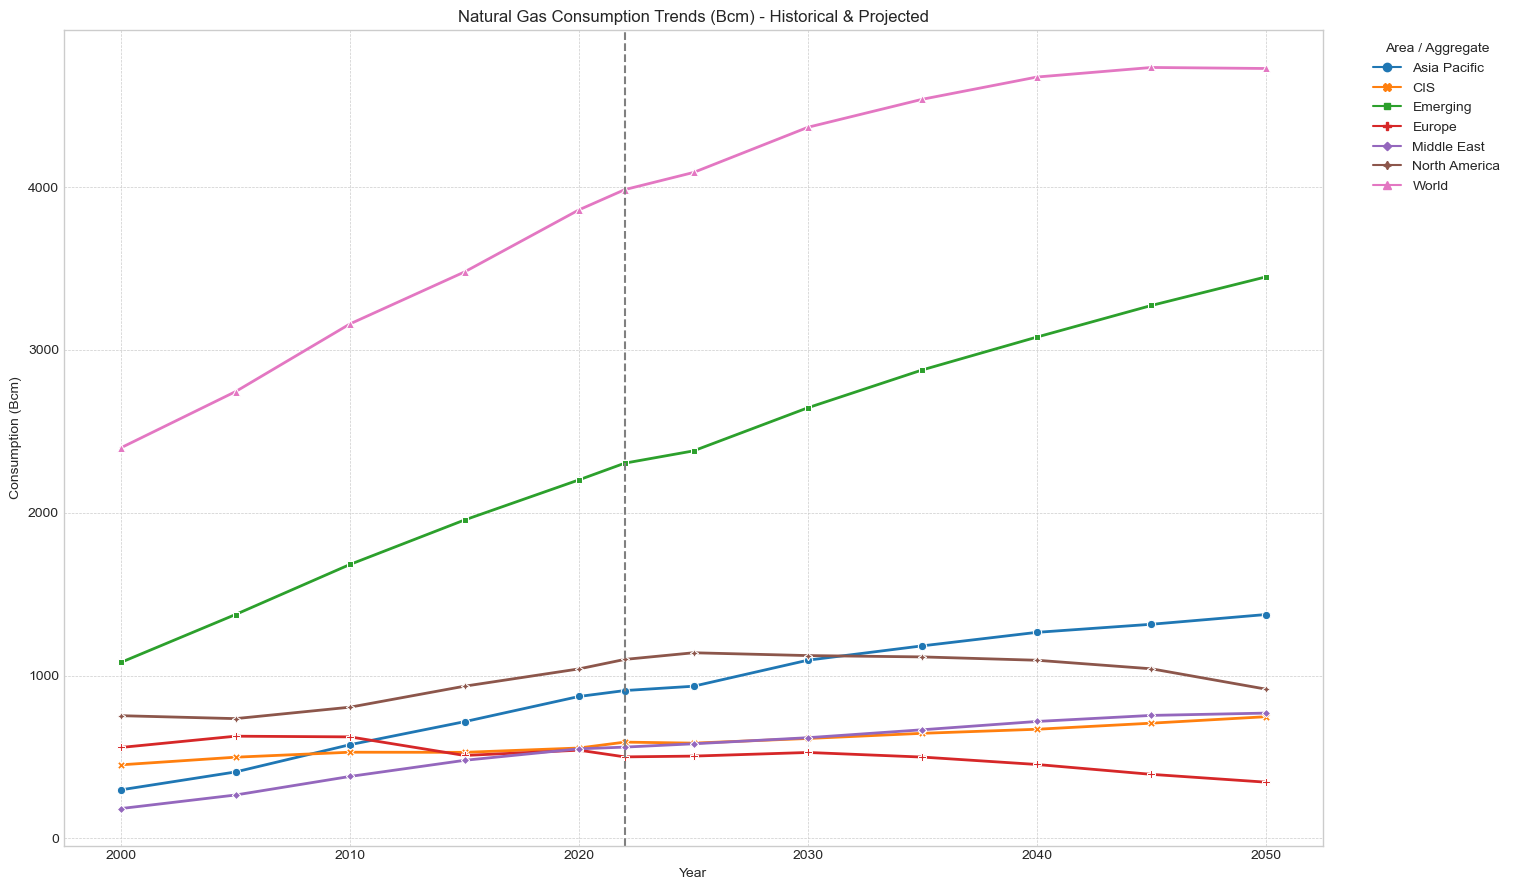

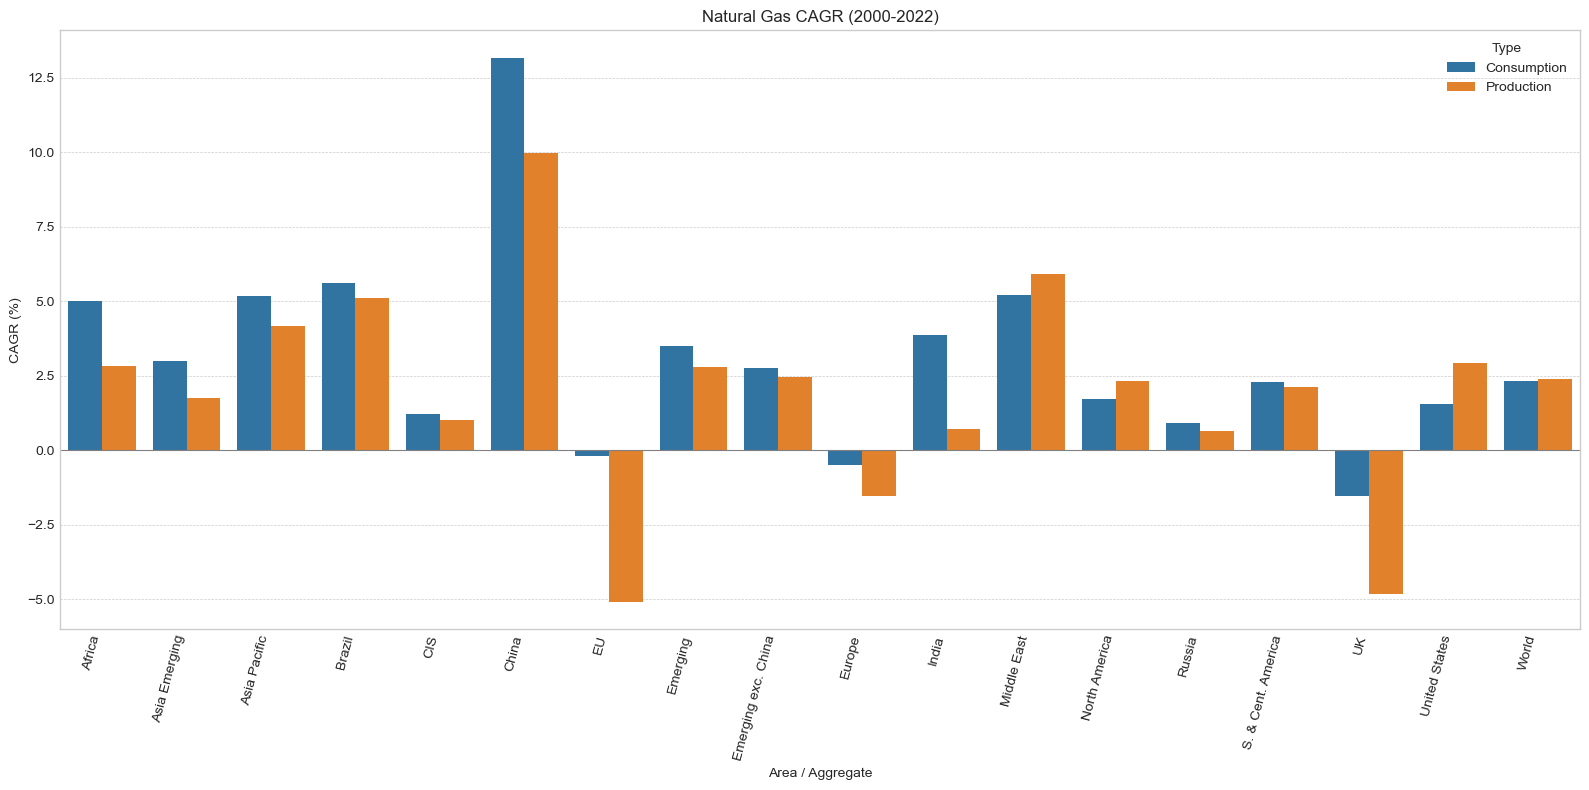

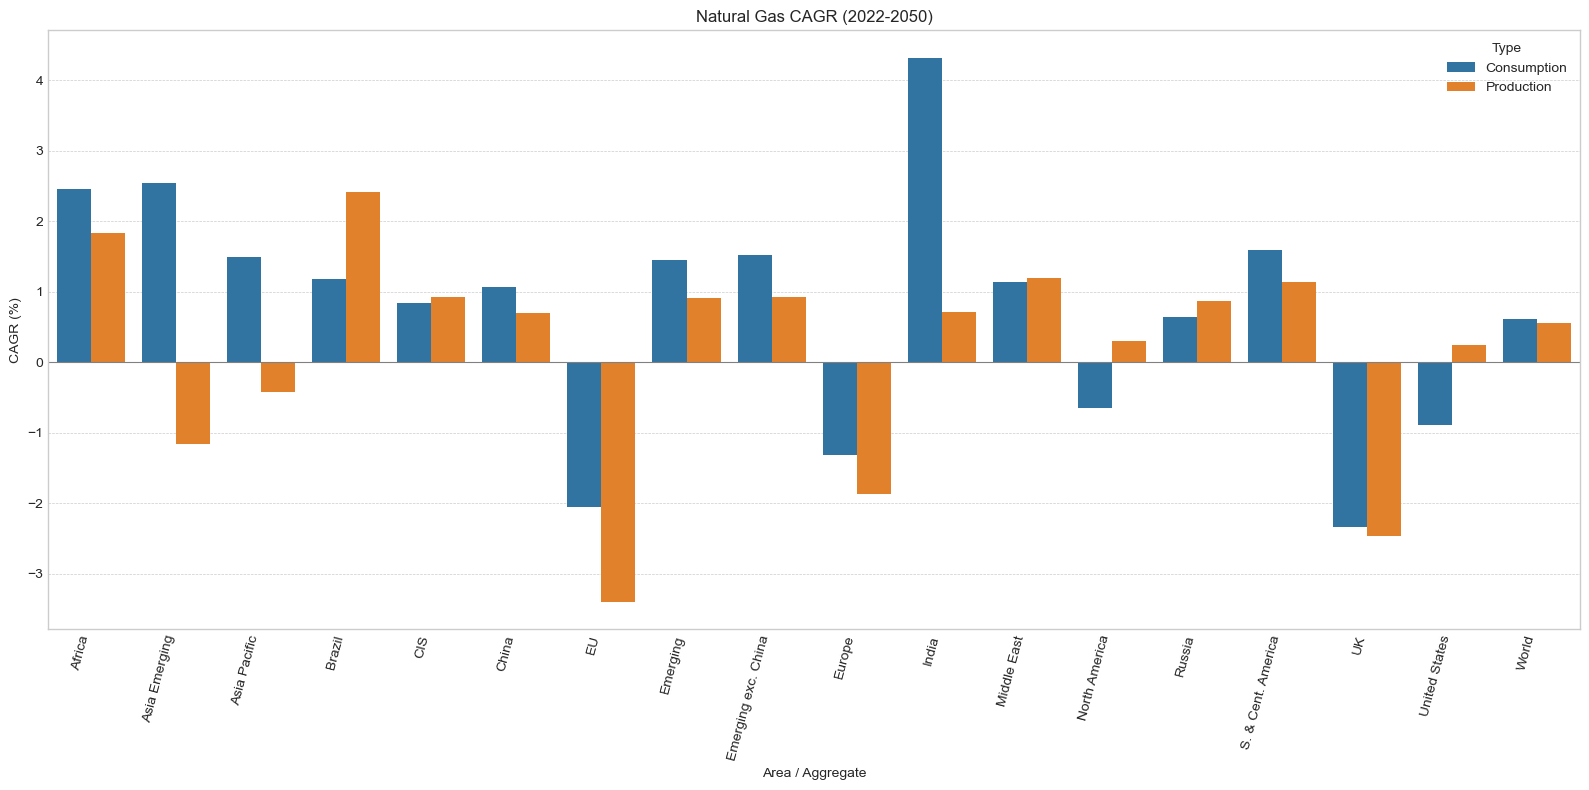

In [12]:
if df_combined is not None and not df_combined.empty:
    plt.style.use('seaborn-whitegrid')  # Using a seaborn style

    # --- Plot Production & Consumption Trends for selected Key Regions/Aggregates ---
    AREAS_FOR_LINE_PLOT = [ # Select a few key ones to avoid clutter, or plot separately
        'World', 'Developed', 'Emerging', 'North America', 'Asia Pacific', 'CIS', 'Middle East', 'Europe'
    ]
    # Ensure 'Developed' is used if 'of which: Developed' was replaced
    AREAS_FOR_LINE_PLOT = [name.replace('of which: Developed', 'Developed') for name in AREAS_FOR_LINE_PLOT]


    df_plot_subset = df_combined[df_combined['Area'].isin(AREAS_FOR_LINE_PLOT)]

    for data_type in ['Production', 'Consumption']:
        plt.figure(figsize=(18, 9))
        sns.lineplot(data=df_plot_subset[df_plot_subset['Type'] == data_type],
                     x='Year', y='Value_Bcm', hue='Area', style='Area', linewidth=2, markers=True, dashes=False)
        plt.title(f'Natural Gas {data_type} Trends (Bcm) - Historical & Projected')
        plt.ylabel(f'{data_type} (Bcm)')
        plt.xlabel('Year')
        # Place legend outside
        plt.legend(title='Area / Aggregate', bbox_to_anchor=(1.03, 1), loc='upper left')
        plt.axvline(HISTORICAL_END_YEAR, color='grey', linestyle='--', lw=1.5, label=f'Projection Start ({HISTORICAL_END_YEAR})')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
        plt.savefig(f'{data_type.lower()}_trends_full_outlook.png', bbox_inches='tight')
        plt.show()

    # --- Bar Chart for CAGR Comparison ---
    if 'df_cagr' in locals() and not df_cagr.empty:
        # Plot historical and projected CAGRs separately or faceted
        for period_type in [f'{HISTORICAL_START_YEAR}-{HISTORICAL_END_YEAR}', f'{HISTORICAL_END_YEAR}-{PROJECTED_END_YEAR}']:
            plt.figure(figsize=(16, 8))
            sns.barplot(data=df_cagr[df_cagr['CAGR_Period'] == period_type], x='Area', y='CAGR_%', hue='Type', dodge=True)
            plt.title(f'Natural Gas CAGR ({period_type})')
            plt.ylabel('CAGR (%)')
            plt.xlabel('Area / Aggregate')
            plt.xticks(rotation=75, ha='right')
            plt.axhline(0, color='grey', lw=0.8)
            plt.legend(title='Type')
            plt.grid(axis='y', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.savefig(f'cagr_comparison_{period_type.replace("-","_")}.png')
            plt.show()
else:
    print("Skipping visualizations as df_combined is not available or empty.")

 Prepare Data for Power BI

In [13]:
if df_combined is not None and not df_combined.empty:
    output_csv_path_main = 'natural_gas_outlook_data_for_powerbi.csv'
    df_combined.to_csv(output_csv_path_main, index=False)
    print(f"\nProcessed outlook data saved to {output_csv_path_main}")

    if 'df_cagr' in locals() and not df_cagr.empty:
        output_csv_path_cagr = 'natural_gas_outlook_cagr_for_powerbi.csv'
        df_cagr.to_csv(output_csv_path_cagr, index=False)
        print(f"CAGR data saved to {output_csv_path_cagr}")
else:
    print("Skipping data export as df_combined is not available or empty.")


Processed outlook data saved to natural_gas_outlook_data_for_powerbi.csv
CAGR data saved to natural_gas_outlook_cagr_for_powerbi.csv
